# Permutation Importance

## 1. Basic Idea

The main idea behind permutation importance is to shuffle the value of one feature column and then check the performance of a pretrained network on this permuted dataset. The performance will probably decrease, but the relative drop will indicate how important the feature is. 

Hence, this method is model agnostic.

Further information can be found on https://arxiv.org/pdf/1801.01489.pdf 

## 2. Algorithm

1. Take a model that was fit to the training set
2. Estimate the predicted performance of the model on a validation dataset and take that as the baseline performance
3. For each feature j:
  
  a. Shuffle all the values of the column in the original dataset (the other columns and labels are fixed)

  b. Record the performance of the shuffeled dataset on the original network 

  c. Compute the feature importance as the absolute difference between the baseline performance and the performance of the shuffeled dataset.

Repeat a - c for a large number of times and average over all trials.

## 3. Permutation Importance applied to a stroke dataset using a Random Forest

In [ ]:
#need newer matplotlib version for nice bar plots
#!pip install matplotlib==3.5.2

In [ ]:
! git clone https://gist.github.com/aishwarya8615/d2107f828d3f904839cbcb7eaa85bd04 'stroke'
! git clone https://github.com/mahmouddraz/xai 'xai_workshop'

Cloning into 'stroke'...
remote: Enumerating objects: 33, done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 33
Unpacking objects: 100% (33/33), done.
Cloning into 'xai_workshop'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 97 (delta 40), reused 73 (delta 23), pack-reused 0
Unpacking objects: 100% (97/97), done.


Preparing the dataset to feed it into a Random Forest Classifier.

In [ ]:
# Imports
import sys 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
#Read data
data = pd.read_csv('/content/stroke/healthcare-dataset-stroke-data.csv')

#Print the data
print(f'We have {len(data)} datapoints. The first ten data points are:')
print(data.iloc[0:10,:].to_markdown()) 

# Load pretrained model and data
with open('/content/xai_workshop/pretrained_networks/rf_stroke/rf_stroke.pickle', "rb") as f:
  rf = pickle.load(f)
with open('/content/xai_workshop/pretrained_networks/rf_stroke/rf_stroke_X_train.pickle', "rb") as f:
  X_train = pickle.load(f)
with open('/content/xai_workshop/pretrained_networks/rf_stroke/rf_stroke_X_test.pickle', "rb") as f:
  X_test = pickle.load(f)
with open('/content/xai_workshop/pretrained_networks/rf_stroke/rf_stroke_y_test.pickle', "rb") as f:
  y_test = pickle.load(f)

We have 5110 datapoints. The first ten data points are:
|    |    id | gender   |   age |   hypertension |   heart_disease | ever_married   | work_type     | Residence_type   |   avg_glucose_level |   bmi | smoking_status   |   stroke |
|---:|------:|:---------|------:|---------------:|----------------:|:---------------|:--------------|:-----------------|--------------------:|------:|:-----------------|---------:|
|  0 |  9046 | Male     |    67 |              0 |               1 | Yes            | Private       | Urban            |              228.69 |  36.6 | formerly smoked  |        1 |
|  1 | 51676 | Female   |    61 |              0 |               0 | Yes            | Self-employed | Rural            |              202.21 | nan   | never smoked     |        1 |
|  2 | 31112 | Male     |    80 |              0 |               1 | Yes            | Private       | Rural            |              105.92 |  32.5 | never smoked     |        1 |
|  3 | 60182 | Female   |    49 |      

Create the Random Forest classifier and train it.

In [ ]:
y_pred = rf.predict(X_test)

print(f"The classifier is trained has an accuracy of {accuracy_score(y_test, y_pred)}.")
baseline_performance = accuracy_score(y_test, y_pred)

The classifier is trained has an accuracy of 0.9442270058708415.


Now we apply permutation importance.

In [ ]:
import numpy as np

runs_per_feature = 50

feature_and_importance = {}

# Iterate over all features
for fx, feature in enumerate(X_test): 

  if feature == "id":
    continue

  importance_in_run = []

  for i in range (0,runs_per_feature):

    # Shuffle the values of the column
    permuted_data = X_test.copy()
    permuted_data[feature] = np.random.permutation(permuted_data[feature].values)

    # Test the classifier on the new dataset
    y_pred = rf.predict(permuted_data)
    permuted_accuracy = accuracy_score(y_test, y_pred)

    # Save the difference of the baseline performance and new performance
    importance_in_run.append(baseline_performance - permuted_accuracy)

  # Compute average
  feature_and_importance[feature] = abs(sum(importance_in_run) / len(importance_in_run))

Finally we may want to plot the results.

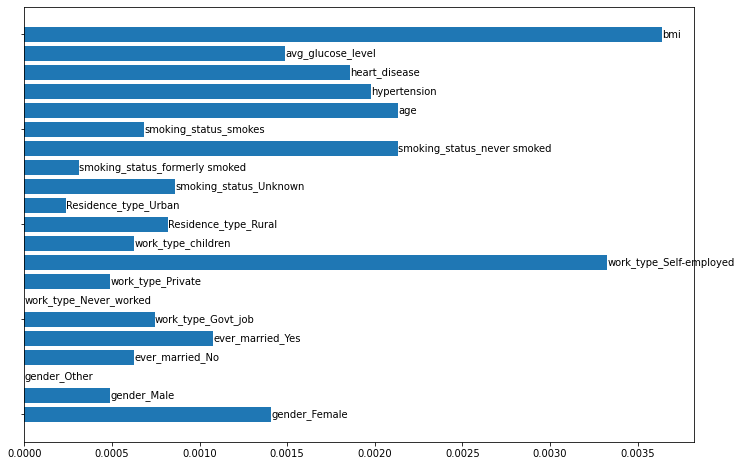

In [ ]:
fig, ax = plt.subplots(figsize=[12, 8])
bars = ax.barh(np.arange(len(feature_and_importance)), feature_and_importance.values())

ax.bar_label(bars, labels=feature_and_importance.keys())
ax.set_yticklabels([])
plt.show()

## 4. Exercises

Answer the following questions:


1. What happens if we increase the number of `runs_per_feature`? What happens if we decrease it? Explain your reasoning.
2. What changes if we just set one feature to zero instead of shuffeling the values?
3. What happens if we use the same method for a neural network? Please check the code below:

In [ ]:
from tensorflow import keras 
import tensorflow as tf 
from tensorflow.keras import layers, models

In [ ]:
with open('/content/xai_workshop/pretrained_networks/nn_stroke/nn_stroke_X_train.pickle', "rb") as f:
  X_train = pickle.load(f)
with open('/content/xai_workshop/pretrained_networks/nn_stroke/nn_stroke_X_test.pickle', "rb") as f:
  X_test = pickle.load(f)
with open('/content/xai_workshop/pretrained_networks/nn_stroke/nn_stroke_y_test.pickle', "rb") as f:
  y_test = pickle.load(f)

nn = keras.models.load_model('/content/xai_workshop/pretrained_networks/nn_stroke/nn_stroke')

In [ ]:
#Compute the baseline performance
y_pred = nn.predict(X_test)

print(f"The classifier is trained has an accuracy of {accuracy_score(y_test, np.round(abs(y_pred)), normalize=True) }.")
baseline_performance = accuracy_score(y_test, np.round(abs(y_pred)), normalize=True)

The classifier is trained has an accuracy of 0.9403131115459883.


Again we implement permutation importance for the trained network.

In [ ]:
runs_per_feature = 50

feature_and_importance = {}

# Iterate over all features
for fx, feature in enumerate(X_test): 

  if feature == "id":
    continue

  importance_in_run = []

  for i in range (0,runs_per_feature):

    # Shuffle the values of the column
    permuted_data = X_test.copy()
    permuted_data[feature] = np.random.permutation(permuted_data[feature].values)

    # Test the classifier on the new dataset
    y_pred = nn.predict(permuted_data)
    permuted_accuracy = accuracy_score(y_test, np.round(abs(y_pred)), normalize=True) 

    # Save the difference of the baseline performance and new performance
    importance_in_run.append(baseline_performance - permuted_accuracy)

  # Compute average
  feature_and_importance[feature] = abs(sum(importance_in_run) / len(importance_in_run))

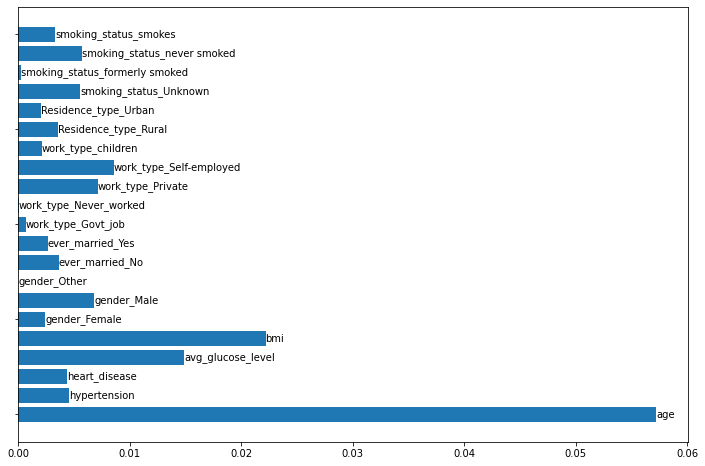

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[12, 8])
bars = ax.barh(np.arange(len(feature_and_importance)), feature_and_importance.values())

ax.bar_label(bars, labels=feature_and_importance.keys())
ax.set_yticklabels([])
plt.show()